In [3]:
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import gsw
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
plt.rcParams['font.size']=14

In [4]:
#constants through out this notebook
# derive the thermal wind based on a linear EOS
g=9.81
f=gsw.f(-65) 
alpha0=1e-4
rho0=1035

# Compare Bathymetry

In [1]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds



In [5]:
bat=xr.open_dataset('/home/birte/MAUD_RISE_config/maud_v4/m12_mask/1_domain_cfg_50levels_new.nc')
bat

<xarray.Dataset>
Dimensions:       (x: 295, y: 270, z: 50)
Dimensions without coordinates: x, y, z
Data variables: (12/41)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    jpiglo        int32 ...
    jpjglo        int32 ...
    jpkglo        int32 ...
    ...            ...
    e3f_0         (z, y, x) float64 ...
    e3uw_0        (z, y, x) float64 ...
    e3vw_0        (z, y, x) float64 ...
    bottom_level  (y, x) int32 ...
    top_level     (y, x) int32 ...
    bathy_meter   (y, x) float32 ...

In [6]:

dist_x=gsw.distance(bat.nav_lon.isel(y=190).values,bat.nav_lat.isel(y=190).values)
cumdist_x=np.zeros(295)
cumdist_x[1:]=dist_x.cumsum()+0.4e6


dist_y=gsw.distance(bat.nav_lon.isel(x=92).values,bat.nav_lat.isel(x=92).values)
cumdist_y=np.zeros(270)
cumdist_y[1:]=dist_y.cumsum()#+0.4e6

In [7]:
dsg = open_mncdataset('run_bump5000_barotrop/grid', 2, 3, None)

In [10]:
bat.coords['cumdist_x']=bat.x*0+cumdist_x
bat.coords['cumdist_y']=bat.y*0+cumdist_y-150000
bat

<xarray.Dataset>
Dimensions:       (x: 295, y: 270, z: 50)
Coordinates:
    cumdist_x     (x) float64 0.0 4.04e+05 4.08e+05 ... 1.568e+06 1.572e+06
    cumdist_y     (y) float64 -1.5e+05 -1.469e+05 ... 8.466e+05 8.51e+05
Dimensions without coordinates: x, y, z
Data variables: (12/41)
    nav_lon       (y, x) float32 -5.083 -5.0 -4.917 -4.833 ... 19.25 19.33 19.42
    nav_lat       (y, x) float32 -70.53 -70.53 -70.53 ... -61.53 -61.53 -61.53
    nav_lev       (z) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
    jpiglo        int32 295
    jpjglo        int32 270
    jpkglo        int32 50
    ...            ...
    e3f_0         (z, y, x) float64 ...
    e3uw_0        (z, y, x) float64 ...
    e3vw_0        (z, y, x) float64 ...
    bottom_level  (y, x) int32 0 0 0 0 0 0 0 0 0 ... 48 48 48 48 48 48 48 48 48
    top_level     (y, x) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
    bathy_meter   (y, x) float32 7.168 7.168 7.168 ... 5.031e+03 5.051e+03

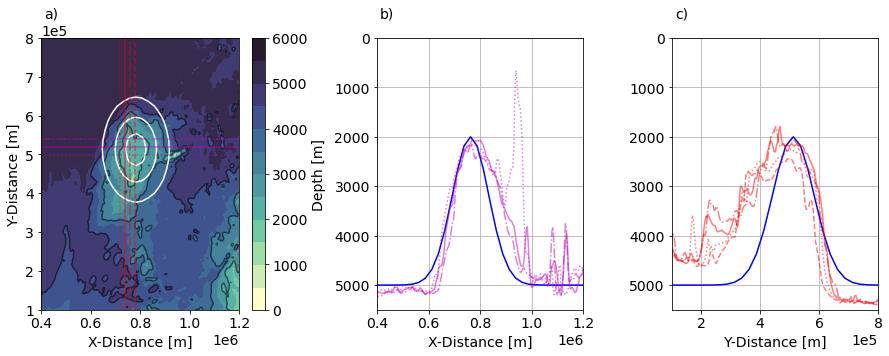

In [18]:
fig,axes=plt.subplots(1,3,figsize=(15,5),gridspec_kw={'width_ratios':[1.2,1,1],'wspace':.4})
ax=axes[0]
#cb=ax.contourf(bat.cumdist_x,bat.cumdist_y,bat.bathy_meter,vmin=0,vmax=6000,levels=13,cmap=cmo.deep,cbar_kwargs={'label':'Depth [m]'})
#ax.contour(bat.cumdist_x,bat.cumdist_y,bat.bathy_meter,levels=[2500,3500,4500],colors='k',alpha=.5)
cb=bat.bathy_meter.plot.contourf(x="cumdist_x",y="cumdist_y",vmin=0,vmax=6000,levels=13,cmap=cmo.deep,ax=ax,cbar_kwargs={'label':'Depth [m]'})#,add_colorbar=False)
bat.bathy_meter.plot.contour(x="cumdist_x",y="cumdist_y",levels=[2500,3500,4500],colors='k',alpha=.5,ax=ax)
ax.contour(0.02e6+dsg.X,dsg.Y,dsg.Depth,levels=[2500,3500,4500],colors='w')
ax.vlines(bat.cumdist_x.isel(x=80),0.1e6,1e6,colors='r',ls=':',alpha=.5)
ax.vlines(bat.cumdist_x.isel(x=85),0.1e6,1e6,colors='r',ls='-',alpha=.5)
ax.vlines(bat.cumdist_x.isel(x=90),0.1e6,1e6,colors='r',ls='-.',alpha=.5)
ax.vlines(bat.cumdist_x.isel(x=95),0.1e6,1e6,colors='r',ls='--',alpha=.5)

ax.hlines(bat.cumdist_y.isel(y=185),0.4e6,1.2e6,color='m',ls=':',alpha=.5)
ax.hlines(bat.cumdist_y.isel(y=190),0.4e6,1.2e6,color='m',ls='-',alpha=.5)
ax.hlines(bat.cumdist_y.isel(y=195),0.4e6,1.2e6,color='m',ls='-.',alpha=.5)
ax.set_xlim(4e5,12e5)
ax.set_ylim(0.1e6,0.8e6)
ax.ticklabel_format(axis='both', style='scientific', scilimits=[-4,4])#, useOffset=None, useLocale=None, useMathText=None)
ax.set_title('')
ax.set_ylabel('Y-Distance [m]')
ax.set_xlabel('X-Distance [m]')
ax.text(0.05, 1.09, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax=axes[1]
dsg.Depth.isel(Y=20).plot(ax=ax,color='b')
bat.bathy_meter.isel(y=185).plot(x="cumdist_x",ax=ax,color='m',ls=':',alpha=.5)
bat.bathy_meter.isel(y=190).plot(x="cumdist_x",ax=ax,color='m',ls='-',alpha=.5)
bat.bathy_meter.isel(y=195).plot(x="cumdist_x",ax=ax,color='m',ls='-.',alpha=.5)
ax.set_xlim(4e5,12e5)
ax.set_ylim(0,5500)
ax.invert_yaxis()
ax.set_ylabel('')
ax.set_title('')
ax.set_xlabel('X-Distance [m]')
ax.grid()
ax.text(0.05, 1.09, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax=axes[2]
(dsg.Depth.isel(X=30)).plot(ax=ax,color='b')

bat.bathy_meter.isel(x=85).plot(x="cumdist_y",ax=ax,color='r',ls=':',alpha=.5)
bat.bathy_meter.isel(x=90).plot(x="cumdist_y",ax=ax,color='r',ls='-',alpha=.5)
bat.bathy_meter.isel(x=95).plot(x="cumdist_y",ax=ax,color='r',ls='-.',alpha=.5)
bat.bathy_meter.isel(x=80).plot(x="cumdist_y",ax=ax,color='r',ls='--',alpha=.5)
ax.set_ylabel('')
ax.set_title('')
ax.set_xlabel('Y-Distance [m]')
ax.set_xlim(0.1e6,0.8e6)
ax.set_ylim(0,5500)
ax.ticklabel_format(axis='both', style='scientific', scilimits=[-4,4])#, useOffset=None, useLocale=None, useMathText=None)
ax.text(0.05, 1.09, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.invert_yaxis()
ax.grid()
plt.savefig('./figures/comparison_bathy_5000runs.jpg',dpi=300)
